# Technical Report - London Wheelchair Accessibility
This report analyzes wheelchair accessibility data in London venues. The goal of the analysis is to predict which venues currently have a wheelchair ramp installed.

According to a new survery, ~40 percent of venues do not have a wheelchair ramp installed. However, this information is not easily known. The London event venue dataset will help build a model to predict which locations do not have accessible ramps.

Our model will help save time in contacting venues that likely do not have a ramp. The company will also avoid a bad appearance from contacting venues that already have a ramp.

## The Data
Here is a list of the variables in our dataset. Thera are nearly 4,000 venues listed, along with some of their attributes:

- "venue_name" - Character, name of the venue.
- "Loud music / events" - Whether the venue hosts loud events (1) or not (0).
- "Venue provides alcohol" - Numeric, whether the venue provides alcohol (1) or not (0).
- "Wi-Fi" - Character, whether the venue provides wi-fi (True) or not (False).
- "supervenue" - Whether the venue qualifies as a supervenue (1) or not (0).
- "U-Shaped_max" - Numeric, the total capacity of the u-shaped portion of the theatre.
- "max_standing" - Numeric, the total standing capacity of the venue.
- "Theatre_max" - Numeric, the total capacity of the theatre.
- "Promoted / ticketed events" - Whether the venue hosts promoted/ticket events (1) or not (0).
- "Wheelchair accessible" - Whether the venue is wheelchair accessible (1) or not (0).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

sns.set_theme(style = 'whitegrid')
sns.set_context('notebook')
sns.set_palette(['#d597a2','#7BAFD4'])
%matplotlib inline

In [ ]:
# read in data
datafile = "data/event_venues.csv"
venues = pd.read_csv(datafile)

# convert bool to ints and check missing values
map = {True : 1, False : 0}
venues.replace(map, inplace=True)
print(venues.info())
print(venues.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   venue_name                  3910 non-null   object 
 1   Loud music / events         3910 non-null   int64  
 2   Venue provides alcohol      3910 non-null   int64  
 3   Wi-Fi                       3910 non-null   int64  
 4   supervenue                  3910 non-null   int64  
 5   U-Shaped_max                3910 non-null   float64
 6   max_standing                3910 non-null   int64  
 7   Theatre_max                 3910 non-null   float64
 8   Promoted / ticketed events  3910 non-null   int64  
 9   Wheelchair accessible       3910 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 305.6+ KB
None
venue_name                    0
Loud music / events           0
Venue provides alcohol        0
Wi-Fi                         0
supervenue  

# Exploring the Data

After verifying there are no missing data, we calculate summary statistics of our data below. There is a strong indication of outliers in our continuous variables. For example, the largest max standing capacity is 7500, but the 75th percentile is 120. We can confirm this with a boxplot (Figure 1). For better analysis and model performance, we elect to drop the bottom and top 3 percentiles of our data, specifically from the `max_standing` column. Figure 2 shows the new distribution of max standing room with outliers pruned.

In [ ]:
#calculate summary statistics
venues.describe()

,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
count,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000
mean,0.358824,0.713299,0.929412,0.062404,35.045455,114.203581,112.715867,0.379028,0.500000
std,0.479717,0.452278,0.256169,0.241919,43.937591,272.269943,131.853249,0.485207,0.500064
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,35.045455,0.000000,80.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,35.045455,50.000000,112.715867,0.000000,0.500000
75%,1.000000,1.000000,1.000000,0.000000,35.045455,120.000000,112.715867,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,2520.000000,7500.000000,4000.000000,1.000000,1.000000


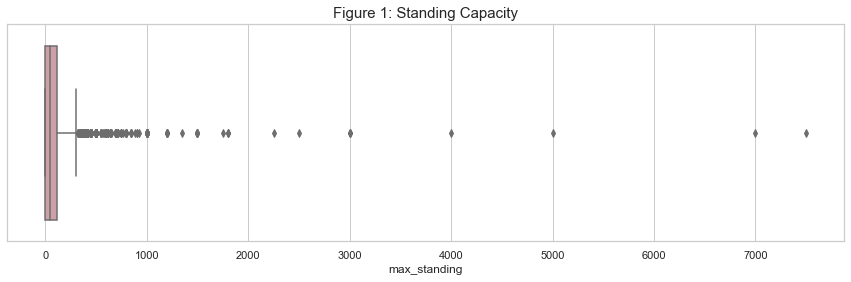

In [ ]:
# boxplot to show outlier presence
plt.subplots(figsize = (15,4))
sns.boxplot(venues['max_standing'])
plt.title("Figure 1: Standing Capacity", fontsize=15)
plt.show()

In [ ]:
# calculate top, bottom 3 percent of
ptile3 = np.percentile(venues['max_standing'], 3)
ptile97 = np.percentile(venues['max_standing'], 97)


venues = venues[(venues['max_standing'] > ptile3) & (venues['max_standing'] < ptile97)]

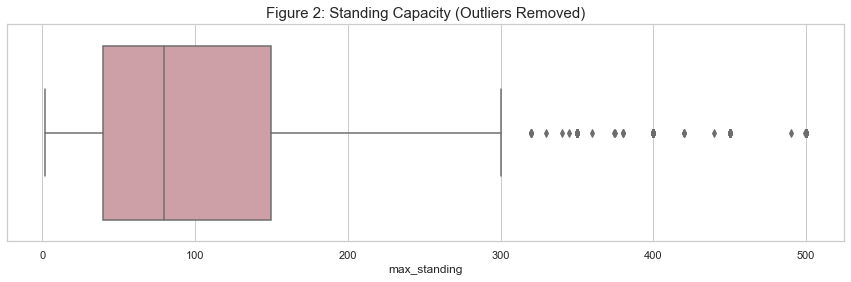

In [ ]:
# replot last plot to show outliers removed
plt.subplots(figsize = (15,4))
sns.boxplot(venues['max_standing'])
plt.title("Figure 2: Standing Capacity (Outliers Removed)", fontsize=15)
plt.show()

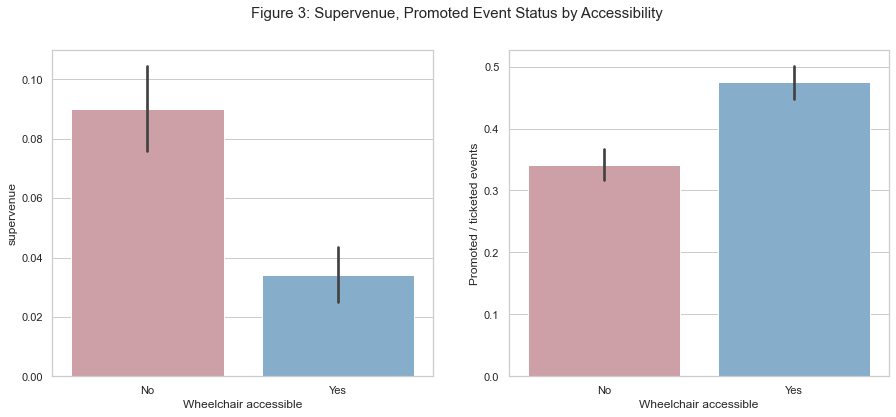

In [ ]:
# make barplots to show differences in accessibility
f,axes = plt.subplots(1,2, figsize=(15,6), sharex=True)

sns.barplot(data=venues, x='Wheelchair accessible', y='supervenue', estimator=np.mean, ax=axes[0])
sns.barplot(data=venues, x='Wheelchair accessible', y='Promoted / ticketed events', estimator=np.mean,
            ax=axes[1])

plt.suptitle("Figure 3: Supervenue, Promoted Event Status by Accessibility", size=15)
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

About 6 percent of venues in the dateset are "supervenues". Supervenues are, however, more than twice as likely to lack wheelchair accessibility. We also see that the proportion of accessible venues with promoted or ticketed events is about 10 percent higher (Figure 3). This information builds a profile of what potential customers may look like. 

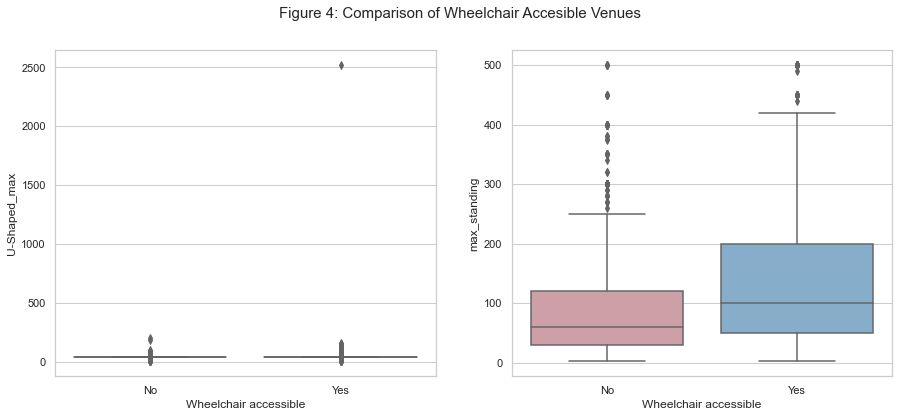

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,6), sharex=True)
fig.suptitle('Figure 4: Comparison of Wheelchair Accesible Venues', fontsize=15)

sns.boxplot(x='Wheelchair accessible', y='U-Shaped_max', data=venues, ax=axes[0])
sns.boxplot(x='Wheelchair accessible', y='max_standing', data=venues, ax=axes[1])

plt.xticks([0,1], ['No', 'Yes'])
plt.show()

The capacity of the u-shaped portion of the theatre is highly constant, so much so that the 25th,50th, and 75th percentile were all ~35. This may not be very useful for visual analysis but our predictive model may make use of this data. This could also be due to data entry error. The median standing room is higher in wheelchair locations. If accessibility is less common in small venues, we might guess that smaller venues may lack the funds for such facilities. Nonetheless, we continue to narrow down potential customers (Figure 4).

# Model Selection

We employ a classification model to predict accessibility. Specifically, we use the AdaBoost Classifier for its ease of use and resistance to overfiting. As shown below, our base model achieved nearly 65% accuracy! We also perform a grid search over our selected hyperparameters for a new accuracy score of 66.3%, giving the desired accuracy. 

In [ ]:
rand_state = 77

X = venues.drop(['venue_name','Wheelchair accessible'], axis='columns')
y = venues['Wheelchair accessible']

# scale only continuous features
ct = ColumnTransformer([('scaler', StandardScaler(), ['max_standing', 'Theatre_max', 'U-Shaped_max'])], remainder='passthrough')
ct.fit_transform(X)

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=rand_state)

# instantiate model, fit
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# 5-fold crossval and print scores
results = cross_validate(model, X_train, y_train, scoring = {'acc':'accuracy'})

print('Untuned Accuracy: %0.3f' % results.get('test_acc').mean())

Untuned Accuracy: 0.649


In [ ]:
# parameters to tune
param_grid= {
    'n_estimators': [100,200,500],
    'learning_rate': [0.05, 0.1, 0.15]
}

# define grid search
grid_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='accuracy')
grid_result = grid_search.fit(X, y)

print("Best: %0.3f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.663 using {'learning_rate': 0.15, 'n_estimators': 200}


# Test Results

On the test set, the model achieved 69% precision. This means that 69% of all positive guesses were positive. This information will help find potential customers faster, while avoiding making the company look bad (Figure 5).

The final model considered theatre maximum capacity and u-shaped maximum capacity to be the most important predictors of accessibility. In fact, standing capacity was the third most important predictor, making size in general an important factor (Figure 6).

Precision: 0.692


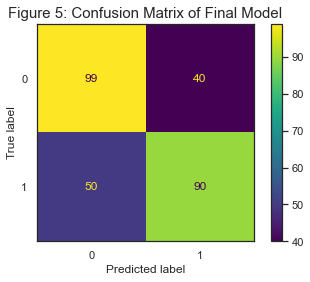

In [ ]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)

sns.set_theme(style='white')
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision)

disp.plot()
plt.title('Figure 5: Confusion Matrix of Final Model', size=15)
plt.show()

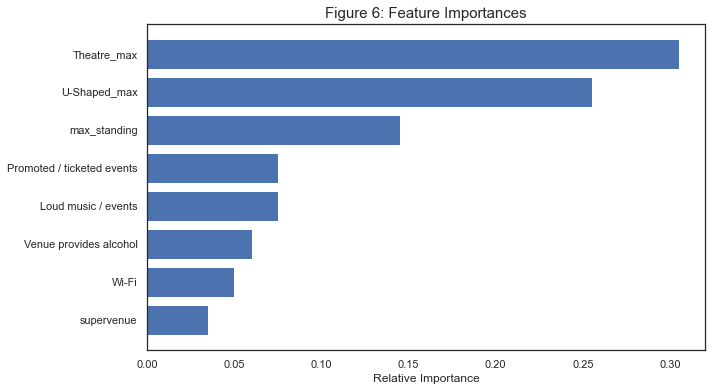

In [ ]:
imps = model.feature_importances_

features = list(X.columns)
indices = np.argsort(imps)

plt.subplots(figsize=(10,6))
plt.title('Figure 6: Feature Importances', size=15)
plt.barh(range(len(indices)), imps[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Outcomes and Future Considerations

In summary, our analysis and model predictors show that size is important to determining venue accessibility. Larger theatres with promoted, ticked events had higher rates of wheelchair accessibility. Also, the classicifation model considered variables related to size to be the most important.

In order to improve model accuracy, a number of things can be done. This includes aquiring more venue data, feature engineering, comparing more models, and more. 

This analysis will help National Accessibility find customers more efficiently and provide accessibility to those who are physically disatvantaged. This will be done by saving time and resources in finding locations in need of our service.